<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Parameters" data-toc-modified-id="Parameters-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Parameters</a></span></li><li><span><a href="#Load-JSON-files-and-correspond-images" data-toc-modified-id="Load-JSON-files-and-correspond-images-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Load JSON files and correspond images</a></span></li><li><span><a href="#Customize-UNITYDataset" data-toc-modified-id="Customize-UNITYDataset-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Customize UNITYDataset</a></span></li><li><span><a href="#Advanced-model-construction" data-toc-modified-id="Advanced-model-construction-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Advanced model construction</a></span><ul class="toc-item"><li><span><a href="#Models'-parameters" data-toc-modified-id="Models'-parameters-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Models' parameters</a></span></li><li><span><a href="#Training-process" data-toc-modified-id="Training-process-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Training process</a></span></li></ul></li><li><span><a href="#Saving-model" data-toc-modified-id="Saving-model-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Saving model</a></span></li><li><span><a href="#Validate-model" data-toc-modified-id="Validate-model-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Validate model</a></span></li><li><span><a href="#Load-trained-model-to-predict" data-toc-modified-id="Load-trained-model-to-predict-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Load trained model to predict</a></span></li><li><span><a href="#Visualization-from-runs" data-toc-modified-id="Visualization-from-runs-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Visualization from <code>runs</code></a></span></li><li><span><a href="#Creating-a-performance-benchmark" data-toc-modified-id="Creating-a-performance-benchmark-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Creating a performance benchmark</a></span></li></ul></div>

# Parameters

In [1]:
import torch

def sci_format(number_in_scientific_notation):
  # Convert the number to a string in scientific notation
  number_str = "{:.1e}".format(number_in_scientific_notation)

  # Check if the exponent contains a leading zero
  if "e-0" in number_str:
      # Remove the leading zero from the exponent
      formatted_exponent = number_str.replace("e-0", "e-")
  else:
      formatted_exponent = number_str

  # Check if the formatted exponent has a decimal point
  if "." in formatted_exponent:
      # Remove the decimal point and extra zeros from the exponent
      formatted_number_str = formatted_exponent.replace(".0e", "e").replace("0e", "e")
  else:
      formatted_number_str = formatted_exponent
  return formatted_number_str

# parameters for adjestment
labels_json = 'backup_23148_4374.json'
# type of image ('vis' or 'mono')
split_ = 'vis'
# The DataLoader needs to know our batch size for training, so we specify it
# here. For fine-tuning ViT on a specific task, the authors recommend a batch
# size of 16 or 32.
batch_size = 4
# Number of training epochs. The BERT authors recommend between 2 and 4.
# Depends on training criterian
epochs = 9

learning_rate = 2.5e-4 # args.learning_rate - default is 5e-5, our notebook would adjust
lr_format = sci_format(learning_rate)

# training records
# a = advance, text = textual approachs, e = epoch, b = batch, lr = learning rate
runs_name = f'a_{split_}_e{epochs}_b{batch_size}_lr{lr_format}'
eps = 1e-7 # args.adam_epsilon  - default is 1e-8.

print(runs_name)
# Saving training process steps and validation process steps
runs_output = f"./output/runs/{runs_name}"
# Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()
output_dir = f'./output/checkpoints/{runs_name}'

# If there's a GPU available...
if torch.cuda.is_available():

    # Tell PyTorch to use the GPU.
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")


a_vis_e9_b4_lr2.5e-4
No GPU available, using the CPU instead.


# Load JSON files and correspond images

In [2]:
import glob
import numpy as np
import pandas as pd
import torch
import ast
import re
import os
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import random_split
from PIL import Image

def convert_to_list(data):
    return ast.literal_eval(data)


current_path = os.getcwd()
text_path = os.path.join(current_path, 'alignment_pptx_list.csv')
# Since it take too much time on traversal ppt files, Easily to import the dataframe from the csv file
df_da = pd.read_csv(text_path, converters={'shape_type': convert_to_list})
df_da = df_da[~df_da['contents'].isnull()]

In [3]:
# filter out less than 4 words
df_da['word_count'] = df_da['contents'].apply(lambda x: len(str(x).split()) if pd.notna(x) else 0)
df_few_words = df_da[~(df_da['word_count'] <= 4)]
df_few_words.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23148 entries, 0 to 26467
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   file_name   23148 non-null  object
 1   page_num    23148 non-null  int64 
 2   shape_type  23148 non-null  object
 3   contents    23148 non-null  object
 4   word_count  23148 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 1.1+ MB


- In this procedure, we would like to handle image names in JSON downloaded from **Label-Studio**. Since image names in **Label-Studio** get garbled when they exceed a certain length, we need to refine them.

- We only deal with **22348** (KTR number) so far, the rest of nummbers ignore as following cells.  

In [ ]:
df_json = pd.read_json(os.path.join(current_path, 'output', 'LABELS', labels_json))
# have done for annotations
df_json = df_json[df_json['annotations'].apply(lambda x: len(x) != 0)]
# annotation results exist
df_json = df_json[df_json['annotations'].apply(lambda x: len(x[0]['result']) != 0)]
# 22348 for 13th slide
count = 13

df_few_words['label'] = ''

for idx, row in enumerate(df_json.iterrows()):
  slide = row[1]
  image_path = slide['data']['image']
  choice = slide['annotations'][0]['result'][0]['value']['choices'][0]
  # print(file_path, choice)
  if image_path.find('22348')!=-1:
    # print(image_path, choice)
    new_image_name = image_path.split('.')[0] + '_' + str(count) + '.PNG'
    # update new name that matches length limitation
    slide['data']['image'] = new_image_name
    image_path = new_image_name
    print(image_path)
    count += 1

  # get page number
  if image_path.split('.')[0].split('_')[-1].isdigit():
    page = int(image_path.split('.')[0].split('_')[-1])
  else:
    page = 0

  # given 'Angebot\ktr' as a condition
  ktr = image_path.split('-')[1].split('_')[0]
  ktr = 'Angebot\\'+ ktr
  ktr = re.escape(ktr)

  # some issues that it should modify manually
  if (ktr == '22348' and page == 13):
    df_few_words.loc[(df_few_words['file_name'].str.contains(ktr)) & (df_few_words['page_num'] == page), 'label'] = 'Initial Situation'
    continue
  elif (ktr == '22348' and page == 14):
    df_few_words.loc[(df_few_words['file_name'].str.contains(ktr)) & (df_few_words['page_num'] == page), 'label'] = 'Target Situation'
    continue

  df_few_words.loc[(df_few_words['file_name'].str.contains(ktr)) & (df_few_words['page_num'] == page), 'label'] = choice

df_few_words.info()


# Customize UNITYDataset

Since we need to customise our dataset that can be used in pytorch, `JSON` file provides annotations and image file names

In [ ]:
import os
import random
import pandas as pd
import torch
import torchvision.transforms as trns
from PIL import Image
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from decimal import Decimal

class UNITYDataset(Dataset):
    def __init__(self, transform, split='vis', img_size=384):
        self.data = []
        self.png_dict = {}
        self.img_size = img_size
        self.transform = transform
        self.split = split
        self.imgs_path = f'./output/mmocr_pre/{self.split}'
        file_list = [file for file in os.listdir(self.imgs_path)]
        # print(file_list)
        # create dictionary
        for i in file_list:
          ktr, page = i.split('/')[-1].split('_')[0], i.split('/')[-1].split('_')[-1].split('.')[0]
          png_page = int(page)
          self.png_dict[(ktr, png_page)] = i

        # since the string names are too long, we would like to ignore them. So pick snippet as key words
        long_name_list = ['20830_Further_Support_Enhancing']
        # corressponding
        for row in df_json.iterrows():
          jump = False
          image_path = row[1]['data']['image']
          for long_name in long_name_list:
            if long_name in image_path:
              # print(f'ignore: {image_path}')
              jump = True
              break

          # ignore long string file name
          if jump:
            continue
          print(image_path)

          ktr = image_path.split('-')[1].split('_')[0]
          page_num = int(image_path.split('/')[-1].split('.')[0].split('_')[-1])
          choice = row[1]['annotations'][0]['result'][0]['value']['choices'][0]
          # we do not consider 'Others' category
          if choice!= 'Others':
            self.data.append([self.png_dict[(ktr, page_num)], choice])
            # print(self.png_dict[(ktr, page_num)], choice)


        self.class_map = {'Competencies': 0,
                          'Consultant Profile':1,
                          'Initial & Target Situation':2,
                          'Initial Situation':3,
                          'Offer Title':4,
                          'Project Calculation':5,
                          'Reference Details':6,
                          'Reference Overview':7,
                          'Target Situation':8,
                          'Working Package Description':9,
                          'Working Package Examples':10,
                          'Working Package Overview':11,
                    }

        self.img_dim = (self.img_size, self.img_size)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path, label_name = self.data[idx]
        read_path = os.path.join(self.imgs_path, img_path)

        if self.split == 'vis':
            img = Image.open(read_path).convert('RGB')
        elif self.split == 'mono':
            img = Image.open(read_path).convert('L')
            img = Image.merge("RGB", [img]*3)

        if self.transform is not None:
            img = self.transform(img)

        class_id = self.class_map[label_name]

        return img, class_id


def collate_fn(batch):
    return {
        'pixel_values': torch.stack([x[0] for x in batch]),
        'labels': torch.tensor([x[1] for x in batch])
    }


def create_datasets(train_transform, test_transform, batch_size=4, train_ratio=0.8, random_seed=42):
    # Set the random seed for reproducibility
    np.random.seed(random_seed)

    # Create the dataset with the specified transform
    dataset = UNITYDataset(transform=train_transform, split=split_, img_size=384)
    train_ratio = str(train_ratio)
    val_ratio = float((Decimal('1.0') - Decimal(train_ratio))/2)
    train_ratio = float(train_ratio)
    # Calculate the split indices
    num_samples = len(dataset)
    num_train_samples = int(num_samples * train_ratio)
    num_val_samples = int(num_samples * val_ratio)

    indices = list(range(num_samples))
    np.random.shuffle(indices)  # Shuffle the indices using the same random seed

    train_indices = indices[:num_train_samples]
    val_indices = indices[num_train_samples:num_train_samples+num_val_samples]
    test_indices = indices[num_train_samples+num_val_samples:]

    print(f'train: {len(train_indices)}')
    print(f'validation: {len(val_indices)}')
    print(f'test:{len(test_indices)}')

    # Create train, validation, and test samplers
    train_sampler = SubsetRandomSampler(train_indices)
    val_sampler = SubsetRandomSampler(val_indices)
    test_sampler = SubsetRandomSampler(test_indices)

    # Create data loaders for train, validation, and test datasets
    train_loader = DataLoader(dataset, batch_size=batch_size, sampler=train_sampler, collate_fn=collate_fn, num_workers=2)
    val_dataset = UNITYDataset(transform=test_transform, split=split_, img_size=384)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, sampler=val_sampler, collate_fn=collate_fn, num_workers=2)
    test_dataset = UNITYDataset(transform=test_transform, split=split_, img_size=384)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, sampler=test_sampler, collate_fn=collate_fn, num_workers=2)

    label2id = {}
    id2label = {}

    for class_name, id in dataset.class_map.items():
        label2id[class_name] = id
        id2label[id] = class_name

    return train_loader, val_loader, test_loader, label2id, id2label
# ////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////

# Define the transformations for train and test datasets
train_transform = trns.Compose([
    trns.Resize((384, 384)),
    trns.RandomHorizontalFlip(p=0.5),
    trns.RandomResizedCrop((384, 384), scale=(0.8, 1.0), ratio=(0.75, 1.3333333333333333), interpolation=2),
    trns.ToTensor(),
    trns.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

test_transform = trns.Compose([
    trns.Resize((384, 384)),
    trns.ToTensor(),
    trns.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

# Create train and test datasets with the specified train_ratio
train_dataloader, val_dataloader, test_dataloader, label2id, id2label = create_datasets(train_transform, test_transform, batch_size, train_ratio=0.8)

# save tensor for performance evaluation
if split_ == 'vis':
  torch.save(test_dataloader, './output/others/vis_test_dataloader.pth')
else:
  torch.save(test_dataloader, './output/others/mono_test_dataloader.pth')

# Advanced model construction

In [ ]:
# import pytorch_lightning as pl
from transformers import ViTForImageClassification, AdamW
from torch.optim import Adam
import torch.nn as nn

In [ ]:
model = ViTForImageClassification.from_pretrained('kakaobrain/vit-large-patch16-384',
                                                  num_labels=12,
                                                  ignore_mismatched_sizes=True,
                                                  id2label=id2label,
                                                  label2id=label2id,
                                                  output_attentions = False, # Whether the model returns attentions weights.
                                                  output_hidden_states = False, # Whether the model returns all hidden-states
                                            )
model.cuda()
print(model)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at kakaobrain/vit-large-patch16-384 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 1024]) in the checkpoint and torch.Size([12, 1024]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([12]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 1024, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-23): 24 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_f

## Models' parameters

In [ ]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The ViT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:4]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[4:20]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The ViT model has 392 different named parameters.

==== Embedding Layer ====

vit.embeddings.cls_token                                (1, 1, 1024)
vit.embeddings.position_embeddings                      (1, 577, 1024)
vit.embeddings.patch_embeddings.projection.weight       (1024, 3, 16, 16)
vit.embeddings.patch_embeddings.projection.bias              (1024,)

==== First Transformer ====

vit.encoder.layer.0.attention.attention.query.weight    (1024, 1024)
vit.encoder.layer.0.attention.attention.query.bias           (1024,)
vit.encoder.layer.0.attention.attention.key.weight      (1024, 1024)
vit.encoder.layer.0.attention.attention.key.bias             (1024,)
vit.encoder.layer.0.attention.attention.value.weight    (1024, 1024)
vit.encoder.layer.0.attention.attention.value.bias           (1024,)
vit.encoder.layer.0.attention.output.dense.weight       (1024, 1024)
vit.encoder.layer.0.attention.output.dense.bias              (1024,)
vit.encoder.layer.0.intermediate.dense.weight           (

In [ ]:
from transformers import get_linear_schedule_with_warmup

# Note: AdamW is a class from the huggingface library (as opposed to pytorch)
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = AdamW(model.parameters(),
                  lr = learning_rate[0], # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = eps # args.adam_epsilon  - default is 1e-8.
                )

# Total number of training steps is [number of batches] x [number of epochs].
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
import time
import datetime
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))

    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

## Training process

In [ ]:
import random
import numpy as np
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter(runs_output)

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128


# Define early stopping variables
early_stop = False
best_val_loss = float('inf')  # Initialize with a high value
patience = 4  # Number of epochs to wait before stopping if no improvement
no_improvement_count = 0  # Counter for epochs with no improvement

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):

    # ========================================
    #               Training
    # ========================================

    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    for step, batch in enumerate(train_dataloader):

        # Unpack this training batch from our dataloader.
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids
        #   [1]: attention masks
        #   [2]: labels
        b_pixels = batch['pixel_values'].to(device)
        # b_input_mask = batch[1].to(device)
        b_labels = batch['labels'].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because
        # accumulating the gradients is "convenient while training RNNs".
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()

        # Perform a forward pass (evaluate the model on this training batch).
        # The documentation for this `model` function is here:
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        # It returns different numbers of parameters depending on what arguments
        # arge given and what flags are set. For our useage here, it returns
        # the loss (because we provided labels) and the "logits"--the model
        # outputs prior to activation.
        outputs = model(b_pixels,
                        labels=b_labels)

        loss = outputs.loss
        logits = outputs.logits

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value
        # from the tensor.
        total_train_loss += loss.item()


        # if step % 40 == 39: # every 40 mini-batches....
        if step % 40 == 0 and not step == 0:
          # Calculate elapsed time in minutes.
          elapsed = format_time(time.time() - t0)
          # Report progress.
          print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

          # ========================================
          #               Validation
          # ========================================
          # After the completion of each training epoch, measure our performance on
          # our validation set.
          print("")
          print(f"Running Validation...({step // 40})")

          t1 = time.time()

          # Put the model in evaluation mode--the dropout layers behave differently
          # during evaluation.
          model.eval()

          # Tracking variables
          total_eval_accuracy = 0
          total_eval_loss = 0
          predictions = []
          true_labels = []

          # Evaluate data for one epoch
          for batch in val_dataloader:

              # Unpack this training batch from our dataloader.
              #
              # As we unpack the batch, we'll also copy each tensor to the GPU using
              # the `to` method.
              #
              # `batch` contains three pytorch tensors:
              #   [0]: input ids
              #   [1]: attention masks
              #   [2]: labels
              b_pixels = batch['pixel_values'].to(device)
              b_labels = batch['labels'].to(device)

              # Tell pytorch not to bother with constructing the compute graph during
              # the forward pass, since this is only needed for backprop (training).
              with torch.no_grad():

                  # Forward pass, calculate logit predictions.
                  # token_type_ids is the same as the "segment ids", which
                  # differentiates sentence 1 and 2 in 2-sentence tasks.
                  # The documentation for this `model` function is here:
                  # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
                  # Get the "logits" output by the model. The "logits" are the output
                  # values prior to applying an activation function like the softmax.

                  outputs = model(b_pixels,
                                  labels=b_labels)

                  loss = outputs.loss
                  logits = outputs.logits

              # Accumulate the validation loss.
              total_eval_loss += loss.item()

              # Move logits and labels to CPU
              logits = logits.detach().cpu().numpy()
              label_ids = b_labels.to('cpu').numpy()

              # Accumulate the predictions and true labels
              predictions.extend(np.argmax(logits, axis=1))
              true_labels.extend(label_ids)

              # Calculate the accuracy for this batch of test sentences, and
              # accumulate it over all batches.
              total_eval_accuracy += flat_accuracy(logits, label_ids)



          # Calculate the average loss over mini-batches.
          avg_train_loss = total_train_loss / 40

          # Calculate the average loss over all of the batches.
          avg_val_loss = total_eval_loss / len(val_dataloader)


          # Report the final accuracy for this validation run.
          avg_val_accuracy = total_eval_accuracy / len(val_dataloader)
          print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

          # Measure how long the validation run took.
          validation_time = format_time(time.time() - t1)

          print("  Validation Loss: {0:.2f}".format(avg_val_loss))
          print("  Validation took: {:}".format(validation_time))

          # Log the running loss averaged per batch
          writer.add_scalars('Training vs. Validation Loss',
                            { 'Training' : avg_train_loss, 'Validation' : avg_val_loss },
                                epoch_i * len(train_dataloader) + step)

          total_train_loss = 0.0

          # Check if validation loss improved
          if avg_val_loss < best_val_loss:
              best_val_loss = avg_val_loss
              no_improvement_count = 0
          else:
              no_improvement_count += 1

          # Check if early stopping condition is met
          if (no_improvement_count >= patience) and early_stop:
              print(f"Early stopping after {epoch_i + 1} epochs without improvement.")
              break  # Exit the training loop


    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)
    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))

    # Check if early stopping condition is met
    if (no_improvement_count >= patience) and early_stop:
      print(f"Early stopping after {epoch_i + 1} epochs without improvement.")
      break  # Exit the training loop


print('Finished Training')
print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))

# Saving model

In [ ]:
# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
# tokenizer.save_pretrained(output_dir)

# Good practice: save your training arguments together with the trained model
# torch.save(args, os.path.join(output_dir, 'training_args.bin'))

# Validate model

In [ ]:
from sklearn.metrics import classification_report
# Convert the predictions and true labels to numpy arrays
predictions = np.array(predictions)
true_labels = np.array(true_labels)

# Generate the classification report
report = classification_report(true_labels, predictions, target_names=['Competencies[0]',
                                                                      'Consultant Profile[1]',
                                                                      'Initial & Target Situation[2]',
                                                                      'Initial Situation[3]',
                                                                      'Offer Title[4]',
                                                                      'Project Calculation[5]',
                                                                      'Reference Details[6]',
                                                                      'Reference Overview[7]',
                                                                      'Target Situation[8]',
                                                                      'Working Package Description[9]',
                                                                      'Working Package Examples[10]',
                                                                      'Working Package Overview[11]'])

# Print the classification report
print(report)

# Load trained model to predict

In [ ]:
from transformers import ViTForImageClassification
# Load a trained model and vocabulary that you have fine-tuned
model = ViTForImageClassification.from_pretrained(output_dir)

# Copy the model to the GPU.
model.to(device)

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 1024, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-23): 24 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_f

In [ ]:
from sklearn.metrics import classification_report
# Prediction on test set
# print('Predicting labels for {:,} test sentences...'.format(test_size))

# Put model in evaluation mode
model.eval()

# Tracking variables
predictions , true_labels = [], []

# Predict
for batch in test_dataloader:
  # Add batch to GPU
  # batch = tuple(t.to(device) for t in batch)

  # Unpack the inputs from our dataloader
  # b_input_ids, b_input_mask, b_labels = batch

  b_pixels = batch['pixel_values'].to(device)
  b_labels = batch['labels'].to(device)

  # Telling the model not to compute or store gradients, saving memory and
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(b_pixels,
                      labels=b_labels)


  loss = outputs.loss
  logits = outputs.logits

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()

  # Store predictions and true labels
  # predictions.extend(np.argmax(logits, axis=1))
  # true_labels.extend(label_ids)
  predictions.append(logits)
  true_labels.append(label_ids)

print('    DONE.')

# print('Positive samples: %d of %d (%.2f%%)' % (df.label.sum(), len(df.label), (df.label.sum() / len(df.label) * 100.0)))

print(predictions)
print(true_labels)

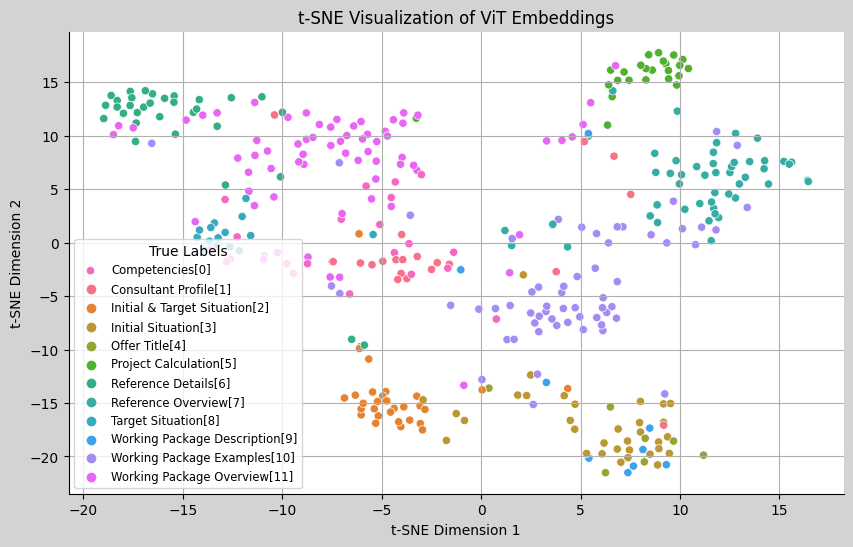

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
# Concatenate the embeddings and labels
embeddings = np.concatenate(predictions)
hue_labels = np.concatenate(true_labels)

# Apply t-SNE for dimensionality reduction
tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(embeddings)

# Map true labels to corresponding class names
class_names = ['Competencies[0]', 'Consultant Profile[1]', 'Initial & Target Situation[2]',
               'Initial Situation[3]', 'Offer Title[4]', 'Project Calculation[5]',
               'Reference Details[6]', 'Reference Overview[7]', 'Target Situation[8]',
               'Working Package Description[9]', 'Working Package Examples[10]',
               'Working Package Overview[11]']

# Create a colormap for different classes
cmap = sns.color_palette("husl", n_colors=len(class_names))

# Use Seaborn to visualize the embeddings
plt.figure(figsize=(10, 6), facecolor='lightgray')
sns.scatterplot(x=embeddings_2d[:, 0], y=embeddings_2d[:, 1], hue=hue_labels,
                palette=cmap, legend='full',)
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.title('t-SNE Visualization of ViT Embeddings')
plt.grid(True)
sns.despine()  # Remove spines from plot

# Move the legend to the bottom right corner
plt.legend(title='True Labels', labels=class_names, fontsize='small', loc='lower left')

plt.show()

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.metrics import matthews_corrcoef

matthews_set = []

ground_true = []
preds = []
# Evaluate each test batch using Matthew's correlation coefficient
print('Calculating Matthews Corr. Coef. for each batch...')

# For each input BATCH...
for i in range(len(true_labels)):

  # The predictions for this batch are a 2-column ndarray (one column for "0"
  # and one column for "1"). Pick the label with the highest value and turn this
  # in to a list of 0s and 1s.
  pred_labels_i = np.argmax(predictions[i], axis=1).flatten()

  # Calculate and store the coef for this batch.
  matthews = matthews_corrcoef(true_labels[i], pred_labels_i)
  matthews_set.append(matthews)
  print(pred_labels_i)
  print(true_labels[i])
  print('------')
  # extend for checking every label
  ground_true.extend(pred_labels_i)
  preds.extend(true_labels[i])

# Create a barplot showing the MCC score for each batch of test samples.
ax = sns.barplot(x=list(range(len(matthews_set))), y=matthews_set, ci=None)

plt.title('MCC Score per Batch')
plt.ylabel('MCC Score (-1 to +1)')
plt.xlabel('Batch #')

plt.show()

In [ ]:
# Combine the results across all batches.
flat_predictions = np.concatenate(predictions, axis=0)

# For each sample, pick the label (0 or 1) with the higher score.
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

# Combine the correct labels for each batch into a single list.
flat_true_labels = np.concatenate(true_labels, axis=0)

# Calculate the MCC
mcc = matthews_corrcoef(flat_true_labels, flat_predictions)

print('Total MCC: %.3f' % mcc)

Total MCC: 0.705


In [ ]:
# Generate the classification report
test_report = classification_report(ground_true, preds, digits = 4,target_names=['Competencies[0]',
                                                                  'Consultant Profile[1]',
                                                                  'Initial & Target Situation[2]',
                                                                  'Initial Situation[3]',
                                                                  'Offer Title[4]',
                                                                  'Project Calculation[5]',
                                                                  'Reference Details[6]',
                                                                  'Reference Overview[7]',
                                                                  'Target Situation[8]',
                                                                  'Working Package Description[9]',
                                                                  'Working Package Examples[10]',
                                                                  'Working Package Overview[11]'])

# Print the classification report
print(test_report)

                                precision    recall  f1-score   support

               Competencies[0]     0.5238    0.6875    0.5946        16
         Consultant Profile[1]     0.9667    0.7632    0.8529        38
 Initial & Target Situation[2]     0.7188    0.6571    0.6866        35
          Initial Situation[3]     0.1111    0.5000    0.1818         2
                Offer Title[4]     0.9583    0.8214    0.8846        28
        Project Calculation[5]     0.7500    0.8000    0.7742        30
          Reference Details[6]     0.7593    0.8723    0.8119        47
         Reference Overview[7]     0.8000    0.5714    0.6667        21
           Target Situation[8]     0.0000    0.0000    0.0000         0
Working Package Description[9]     0.8500    0.7727    0.8095        66
  Working Package Examples[10]     0.7714    0.6923    0.7297        78
  Working Package Overview[11]     0.4500    0.6000    0.5143        15

                      accuracy                         0.7394 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Visualization from `runs`

In [ ]:
# %load_ext tensorboard
# %tensorboard --logdir=./RWTH_master_code/runs --port=444